In [1]:
import warnings
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")

In [2]:
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.layers import (
    LSTM,
    BatchNormalization,
    Dense,
    Dropout,
    Input,
    RepeatVector,
    TimeDistributed,
)
from tensorflow.keras.models import Model, Sequential

In [92]:
# https://raw.githubusercontent.com/hnunezd/DSI/main/real_1.csv
# https://raw.githubusercontent.com/hnunezd/DSI/main/real_8.csv
# https://raw.githubusercontent.com/hnunezd/DSI/main/real_65.csv
# https://raw.githubusercontent.com/hnunezd/DSI/main/real_26.csv
# https://raw.githubusercontent.com/hnunezd/DSI/main/real_27.csv
# https://raw.githubusercontent.com/hnunezd/DSI/main/real_31.csv

url = "https://raw.githubusercontent.com/hnunezd/DSI/main/real_31.csv"
df = pd.read_csv(url)
df

,timestamp,value,is_anomaly
0,1,0,0
1,2,4,0
2,3,145,0
3,4,179,0
4,5,163,0
...,...,...,...
1422,1423,1857,0
1423,1424,1716,0
1424,1425,1691,0
1425,1426,1804,0


In [93]:
anomaly = df[df["is_anomaly"] == 1]

In [94]:
anomaly

,timestamp,value,is_anomaly
1221,1222,1266,1
1222,1223,2615,1
1223,1224,2315,1
1224,1225,2341,1
1225,1226,2153,1
1226,1227,2125,1
1227,1228,2242,1
1228,1229,2089,1
1229,1230,2143,1
1230,1231,2322,1


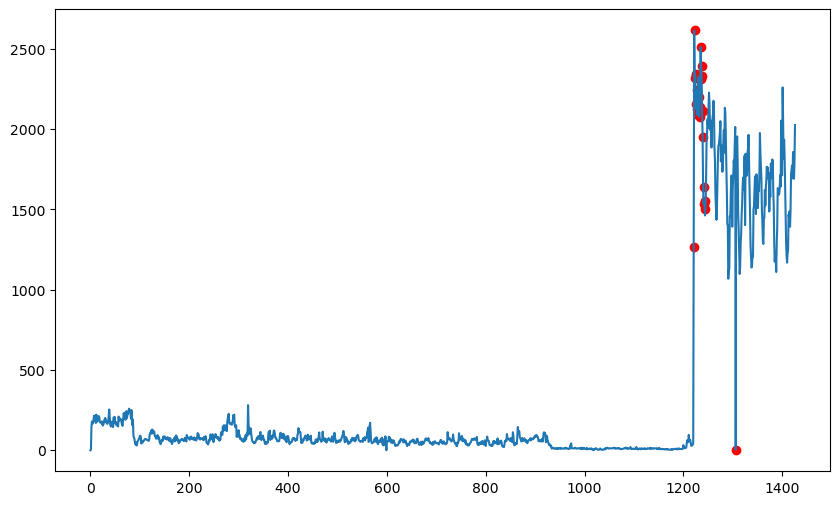

In [95]:
plt.figure(figsize=(10, 6))
plt.plot(df["value"])
plt.scatter(anomaly["timestamp"], anomaly["value"], c="red")
plt.show()

In [96]:
values = df.iloc[:, 1:2]
target = df["is_anomaly"]

In [97]:
test = len(df) - 560

In [98]:
x_train = values[:test]
x_test = values[test : len(df)]

In [99]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_p = scaler.fit_transform(x_train)

In [100]:
scaled_test = scaler.fit_transform(x_test)

In [101]:
def to_sequences(x, seq_size=1):
    x_values = []
    for i in range(len(x) - seq_size):
        x_values.append(scaled_data_p[i : (i + seq_size)])
    return np.array(x_values)

In [102]:
def to_sequences_test(x, seq_size=1):
    x_values = []
    for i in range(round(len(x) / seq_size)):
        x_values.append(scaled_test[i * seq_size : ((1 + i) * seq_size)])
    return np.array(x_values)

In [103]:
seq_size = 8

In [104]:
trainX = to_sequences(x_train, seq_size)
testX = to_sequences_test(x_test, seq_size)

In [105]:
testX.shape

(70, 8, 1)

In [139]:
model = tf.keras.Sequential()
model.add(
    tf.keras.layers.LSTM(
        128, input_shape=(testX.shape[1], testX.shape[2]), return_sequences=True
    )
)
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.LSTM(64, recurrent_dropout=0.2, return_sequences=True))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(0.15))
model.add(tf.keras.layers.LSTM(32, recurrent_dropout=0.2, return_sequences=False))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(0.15))
model.add(tf.keras.layers.RepeatVector(testX.shape[1]))
model.add(tf.keras.layers.LSTM(32, recurrent_dropout=0.2, return_sequences=True))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(0.15))
model.add(tf.keras.layers.LSTM(64, recurrent_dropout=0.2, return_sequences=True))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(0.15))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.ReLU())
model.add(TimeDistributed(Dense(testX.shape[2])))

In [172]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 8, 128)            66560     
                                                                 
 re_lu_24 (ReLU)             (None, 8, 128)            0         
                                                                 
 lstm_25 (LSTM)              (None, 8, 64)             49408     
                                                                 
 re_lu_25 (ReLU)             (None, 8, 64)             0         
                                                                 
 dropout_16 (Dropout)        (None, 8, 64)             0         
                                                                 
 lstm_26 (LSTM)              (None, 32)                12416     
                                                                 
 re_lu_26 (ReLU)             (None, 32)               

In [173]:
tf.random.set_seed(123)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=20, restore_best_weights=True
)

model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.metrics.MeanAbsoluteError()],
)

history = model.fit(
    trainX,
    trainX,
    validation_split=0.2,
    batch_size=80,
    shuffle=False,
    epochs=200,
    callbacks=[early_stopping],
)

Epoch 1/200
9/9 [==============================] - 17s 318ms/step - loss: 0.0039 - mean_absolute_error: 0.0448 - val_loss: 0.0017 - val_mean_absolute_error: 0.0321
Epoch 2/200
9/9 [==============================] - 1s 69ms/step - loss: 0.0028 - mean_absolute_error: 0.0374 - val_loss: 0.0016 - val_mean_absolute_error: 0.0284
Epoch 3/200
9/9 [==============================] - 1s 69ms/step - loss: 0.0037 - mean_absolute_error: 0.0408 - val_loss: 0.0015 - val_mean_absolute_error: 0.0269
Epoch 4/200
9/9 [==============================] - 1s 65ms/step - loss: 0.0037 - mean_absolute_error: 0.0430 - val_loss: 0.0016 - val_mean_absolute_error: 0.0317
Epoch 5/200
9/9 [==============================] - 1s 63ms/step - loss: 0.0035 - mean_absolute_error: 0.0407 - val_loss: 0.0016 - val_mean_absolute_error: 0.0290
Epoch 6/200
9/9 [==============================] - 1s 64ms/step - loss: 0.0032 - mean_absolute_error: 0.0413 - val_loss: 0.0016 - val_mean_absolute_error: 0.0310
Epoch 7/200
9/9 [=========

In [175]:
trainPredict = model.predict(trainX)

27/27 [==============================] - 2s 14ms/step


<AxesSubplot:ylabel='Density'>

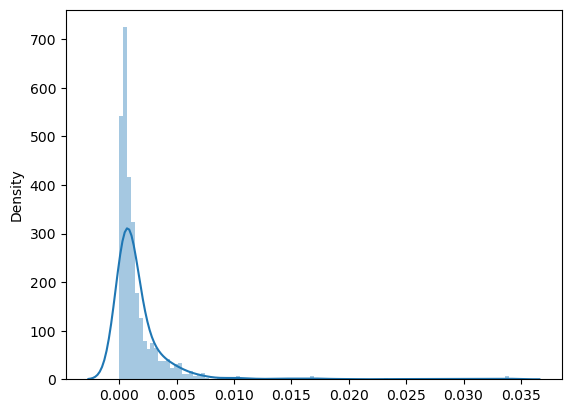

In [176]:
train_mse_loss = np.mean((trainPredict - trainX) ** 2, axis=1)

sns.distplot(train_mse_loss, bins=100, kde=True)

In [177]:
testPredict = model.predict(testX)

3/3 [==============================] - 0s 16ms/step


In [178]:
predit=testPredict.reshape(560,1)

<AxesSubplot:ylabel='Density'>

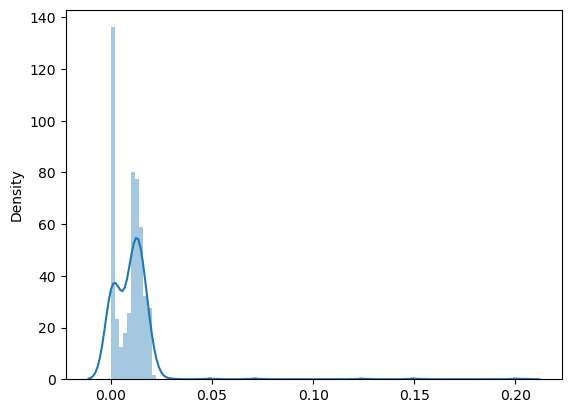

In [179]:
test_mse_loss = (testPredict - testX) ** 2

sns.distplot(test_mse_loss, bins=100, kde=True)

In [181]:
predit = testPredict.reshape(560, 1)

In [182]:
df_1 = pd.DataFrame()

In [183]:
df_1["real"] = pd.DataFrame(scaled_test)

In [184]:
df_1["pred"] = predit

In [185]:
df_1["anomaly"] = target[test : len(df)].values

In [186]:
df_1["error"] = (df_1.real - df_1.pred) ** 2

In [187]:
media = np.mean(df_1.error)
ds = np.std(df_1.error)

In [188]:
lower_p = -3.5 * ds
upper_p = +3.5 * ds

In [189]:
#anomalias_p = df_1[(df_1.error < lower_p) | (df_1.error > upper_p)]
anomalias_p = df_1[df_1.error > upper_p]

In [190]:
anomalias_p

,real,pred,anomaly,error
352,0.012624,0.233281,0,0.048689
353,0.016832,0.404246,0,0.150089
355,1.000000,0.648251,1,0.123727
438,0.769702,0.503432,0,0.070899
439,0.001148,0.449141,1,0.200698


In [191]:
Counter(anomalias_p.anomaly)

Counter({0: 3, 1: 2})

In [192]:
df_1[df_1["anomaly"] == 1]

,real,pred,anomaly,error
354,0.483933,0.540151,1,0.003161
355,1.000000,0.648251,1,0.123727
356,0.885233,0.736736,1,0.022051
357,0.895180,0.779485,1,0.013385
358,0.823259,0.777422,1,0.002101
359,0.812548,0.761741,1,0.002581
360,0.857307,0.781021,1,0.005819
361,0.798776,0.824969,1,0.000686
362,0.819434,0.826615,1,0.000052
363,0.887911,0.831975,1,0.003129


In [193]:
Counter(target[test : len(df)])

Counter({0: 536, 1: 24})

In [194]:
anom=df_1[df_1["anomaly"] == 1]

In [195]:
df_1["score"] = (df_1["error"] - np.min(df_1.error)) / (
    np.max(df_1.error) - np.min(df_1.error)
)

In [196]:
df_1["score"].sort_values(ascending=False).head(30)

439    1.000000
353    0.747835
355    0.616484
438    0.353264
352    0.242599
368    0.142342
356    0.109873
531    0.107140
152    0.096056
168    0.095220
304    0.094832
160    0.094594
312    0.094098
296    0.093771
240    0.093031
288    0.092752
280    0.092512
176    0.092478
208    0.092432
136    0.092192
128    0.091997
328    0.091857
320    0.091557
256    0.091457
232    0.091386
144    0.091379
224    0.091329
72     0.091058
200    0.090721
248    0.090642
Name: score, dtype: float64

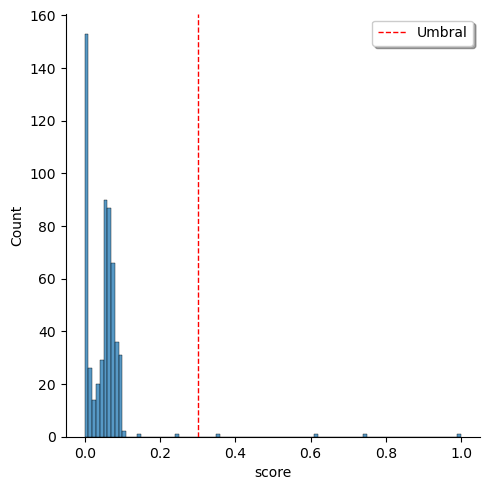

In [197]:
sns.displot(data=df_1, x="score", bins=100)
plt.axvline(0.3, color="red", linewidth=1, linestyle="dashed", label="Umbral")
plt.legend(shadow=True)
#plt.savefig("/Users/hn/OneDrive/Doctorado/Tesis/Proyecto Tesis/fig_examen/autoenc_umbral_8.pdf")
plt.show()

In [198]:
umbral = 0.3

In [199]:
df_1["pred_score"] = np.where(df_1.score > umbral, 1, 0)

In [200]:
df_1[df_1["pred_score"] == 1]

,real,pred,anomaly,error,score,pred_score
353,0.016832,0.404246,0,0.150089,0.747835,1
355,1.000000,0.648251,1,0.123727,0.616484,1
438,0.769702,0.503432,0,0.070899,0.353264,1
439,0.001148,0.449141,1,0.200698,1.000000,1


In [201]:
print(classification_report(df_1.anomaly, df_1.pred_score))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       536
           1       0.50      0.08      0.14        24

    accuracy                           0.96       560
   macro avg       0.73      0.54      0.56       560
weighted avg       0.94      0.96      0.94       560



In [202]:
anom_score=df_1[df_1["pred_score"] == 1]

In [ ]:
plt.figure(figsize=(10, 6))
# plt.xlim(1900,2100)
plt.plot(scaled_test, label="real")
plt.plot(predit,label="predicción")
plt.scatter(anom.index, anom.real, c="red",label="anomalía")
#plt.scatter(anom_score.index, anom_score.real, c="#00ff80", alpha=0.7,marker="*",label="posible anomalía")
plt.legend(shadow=True)
#plt.savefig("/Users/hn/OneDrive/Doctorado/Tesis/Proyecto Tesis/fig_examen/aut_score31.pdf")
plt.show()